## Project Milestone 2 findings (scroll down for PM3 findings)

### Imports

In [1]:
import pandas as pd
from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.tsa.ardl import ARDL
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys

sys.path.append("../src/model")
from ARDL_model import *

sys.path.append("../src/plot_helper")
from ARDL_plot_helper import *


DATA_PATH = "../data/CLEAN"


<h1 style="color: blue;">6. Impact of violent movies on real life violence : autoregressive distributed lag model
 </h1> <a id="ardl"></a>

### Now we start implementing the auto-regressive distributed lag (ARDL) model.

### Model 1: Naive approach 

In the first approach, we do not normalise and take the following values: 

* box office revenues: sum of box office revenues of violent movies released in week i
* violent movie release count: count of violent movies released in week i
* real violence: number of all violent criminal offenses registered in week i

#### All states merged with time-fixed effects:

In [4]:
# Load the final box office revenue data into a dataframe (not normalised)
df_box_offices = pd.read_csv(DATA_PATH+"/Violent_Movies_final.tsv", sep="\t")

In [6]:
# Model 1: load the simple violent offenses count into dataframe -> here: for all states merged
df_real_violence = pd.read_csv(DATA_PATH+"/FBI_91_12/Violence_Score_COUNTS/0_violence_scores_merged.csv", sep=",")

In [7]:
# cut the real_violence dataframe to only include years from 2008 onwards -> to ensure we have complete data for all states
df_real_violence_cut = df_real_violence[df_real_violence['Year'] >= 2008]

In [8]:
# create ARDL model with optimal lags and include time-fixed effects
model_1_with_TFE_all_states = ARDL_model_func(df_box_offices, df_real_violence_cut, time_fixed_effects=True)

In [10]:
# extract the fitted model summary data, return the results dataframe and also store as HTML table (inside function) for embedding into website
results_1_with_TFE_all_states = extract_model_results(model_1_with_TFE_all_states, "Model 1 with TFE all states", "../data/CLEAN/")

In [11]:
# plot the summary of the fitted model (if needed)
#model_1_with_TFE_all_states.summary()

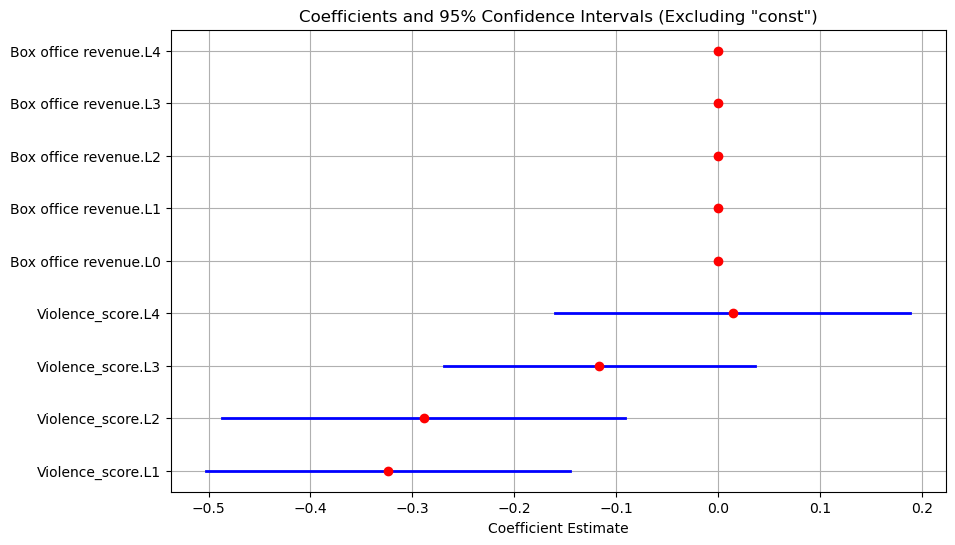

In [12]:
# Plot the 95% confidence intervals for all important coefficients
plot_coefficients_with_confidence_intervals(results_1_with_TFE_all_states)

#### All states merged without time-fixed effects:

In [13]:
# create ARDL model with optimal lags and exclude time-fixed effects
model_1_without_TFE_all_states = ARDL_model_func(df_box_offices, df_real_violence_cut, time_fixed_effects=False)

In [14]:
# extract the fitted model summary data, return the results dataframe and also store as HTML table (inside function) for embedding into website
results_1_without_TFE_all_states = extract_model_results(model_1_without_TFE_all_states, "Model 1 without TFE all states", "../data/CLEAN/")

In [15]:
# plot the summary of the fitted model (if needed)
#model_1_without_TFE_all_states.summary()

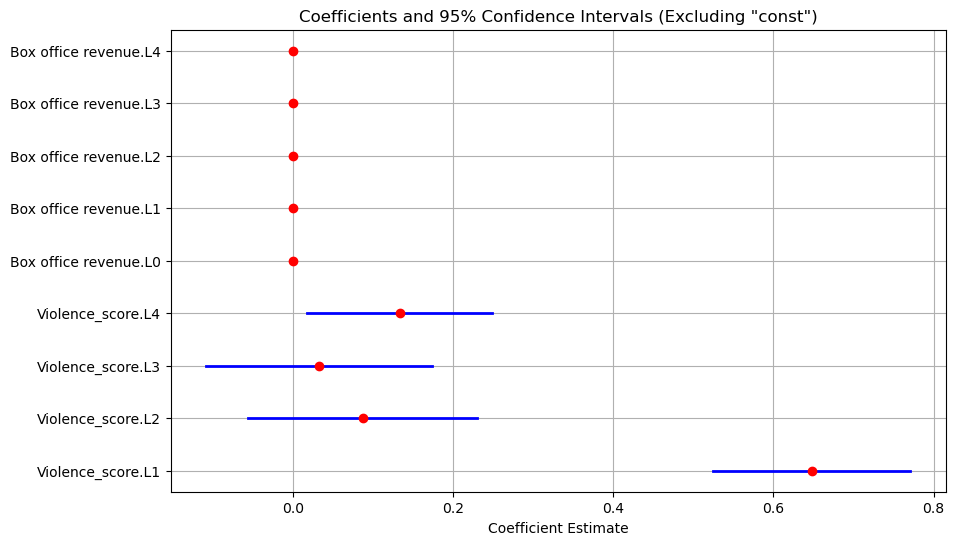

In [16]:
# Plot the 95% confidence intervals for all important coefficients
plot_coefficients_with_confidence_intervals(results_1_without_TFE_all_states)

#### Single state (example here: North Dakota) with time-fixed effects:

In [23]:
# retrieve info about the years for each state for which we have consecutive data
consecutive_years_per_state = pd.read_csv(DATA_PATH+"/FBI_91_12/Consecutive_years_states.tsv", sep="\t")

In [24]:
# fit an optimal ARDL model for each state separately, based on the corresponding consecutive years of data, with time-fixed effects
DIRECTORY_PATH = DATA_PATH + "/FBI_91_12/Violence_Score_COUNTS"
fitted_ARDL_models = ARDL_states_separate(DIRECTORY_PATH, df_box_offices, consecutive_years_per_state, ARDL_model_func, time_fixed_effects=True)

In [26]:
# choose one state of interest -> example here: South Carolina (feel free to choose another one)
model_1_with_TFE_single_state = fitted_ARDL_models["ARDL_SouthCarolina"]

In [27]:
# extract the fitted model summary data, return the results dataframe and also store as HTML table (inside function) for embedding into website
results_1_with_TFE_single_state = extract_model_results(model_1_with_TFE_single_state, "Model 1 with TFE single state", "../data/CLEAN/")

In [50]:
# plot the summary of the fitted model (if needed)
#model_1_with_TFE_single_state.summary()

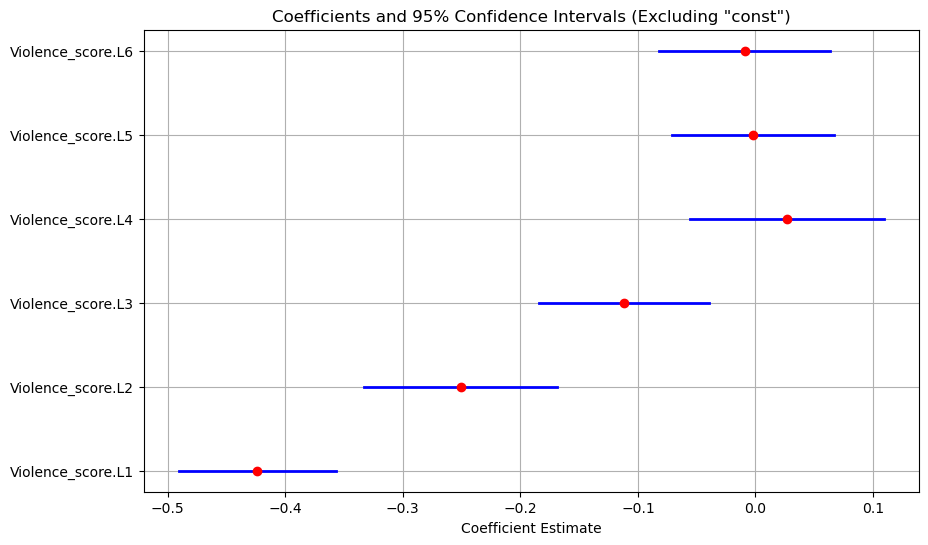

In [28]:
# Plot the 95% confidence intervals for all important coefficients
plot_coefficients_with_confidence_intervals(results_1_with_TFE_single_state)

#### Single state (example here: North Dakota) without time-fixed effects:

In [29]:
# fit an optimal ARDL model for each state separately, based on the corresponding consecutive years of data, without time-fixed effects
fitted_ARDL_models = ARDL_states_separate(DIRECTORY_PATH, df_box_offices, consecutive_years_per_state, ARDL_model_func, time_fixed_effects=False)

In [30]:
# choose one state of interest -> example here: North Dakota (feel free to choose another one)
model_1_without_TFE_single_state = fitted_ARDL_models["ARDL_SouthCarolina"]

In [31]:
# extract the fitted model summary data, return the results dataframe and also store as HTML table (inside function) for embedding into website
results_1_without_TFE_single_state = extract_model_results(model_1_without_TFE_single_state, "Model 1 without TFE single state", "../data/CLEAN/")

In [56]:
# plot the summary of the fitted model (if needed)
#model_1_without_TFE_single_state.summary()

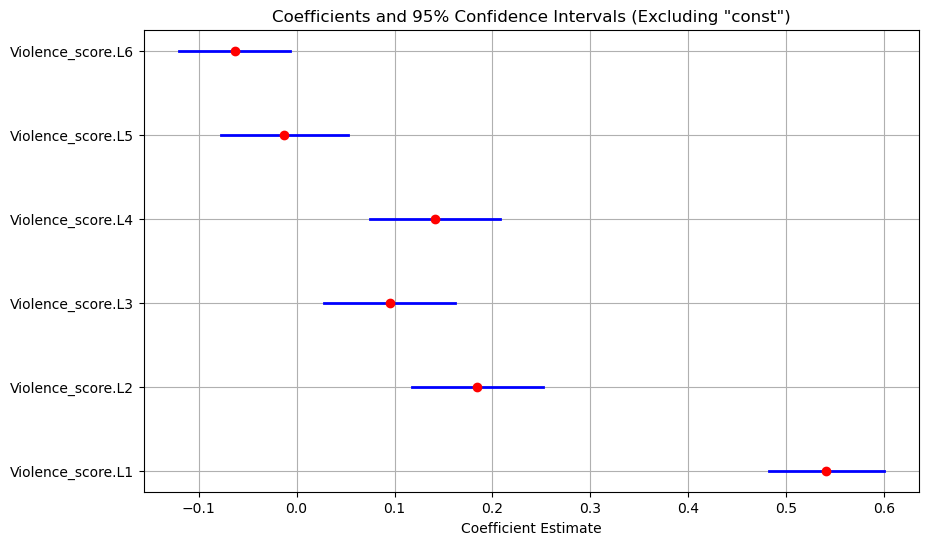

In [32]:
# Plot the 95% confidence intervals for all important coefficients
plot_coefficients_with_confidence_intervals(results_1_without_TFE_single_state)

### Model 2: Violence Offense Ratios

In the second approach, we normalize the real-world violence but keep the box office revenues as they are: 

* box office revenues: sum of box office revenues of violent movies released in week i
* violent movie release count: count of violent movies released in week i
* real violence: number of all criminal offenses registered in week i divided by number of all criminal offenses registered in that year

*Note: Due to the analogous proceeding for all cases (all states/single state, with time-fixed effects/without time-fixed effects) we only show here the results for the example single state North Dakota, since we then can use a longer time period as for all states merged. North Dakota is particularly interesting since we have nearly complete data for 1991 to 2012.*

#### Single state (example here: North Dakota) with time-fixed effects:

In [94]:
def real_life_violence_score_count(data,year,start_week,stop_week,ratio=False): 
    extracted_data = data[(data.year==year) & (data.week >=start_week) & (data.week <=stop_week)]
    weekly_score = extracted_data.groupby("week").size()
    if ratio: 
        weekly_score/=len(extracted_data)

    return weekly_score

In [95]:
data = pd.read_csv("../data/RAW/FBI_91_12/SouthCarolina_violence.csv", sep=",")

all_dataframes = []

# Loop through each year from 1991 to 2012 (inclusive)
for year in range(1991, 2013):  # range's stop is exclusive, so use 2013 to include 2012
    # Call the function for each year with the desired parameters
    weekly_score = real_life_violence_score_count(data, year, start_week=1, stop_week=52, ratio=False)
    
    # Convert the result to a dataframe and add the year as a column
    df = weekly_score.reset_index(name='violence_score')
    df['year'] = year
    
    # Append the dataframe to the list
    all_dataframes.append(df)

# Concatenate all the dataframes in the list into a single dataframe
final_dataframe = pd.concat(all_dataframes, ignore_index=True)

In [97]:
final_dataframe.to_csv("../data/CLEAN/FBI_91_12/SouthCarolina_violence_ratio.csv", sep=",", index=False)

In [101]:
# load violence ratio data for North Dakota
df_real_violence_ratio = pd.read_csv(DATA_PATH+"/FBI_91_12/SouthCarolina_violence_ratio.csv", sep=",")

In [102]:
# create ARDL model with optimal lags and include time-fixed effects
model_2_with_TFE_single_state = ARDL_model_func(df_box_offices, df_real_violence_ratio, time_fixed_effects=True)

In [103]:
# extract the fitted model summary data, return the results dataframe and also store as HTML table (inside function) for embedding into website
results_2_with_TFE_single_state = extract_model_results(model_2_with_TFE_single_state, "Model 2 with TFE single state", "../data/CLEAN/")

In [104]:
# plot the summary of the fitted model (if needed)
#model_2_with_TFE_single_state.summary()

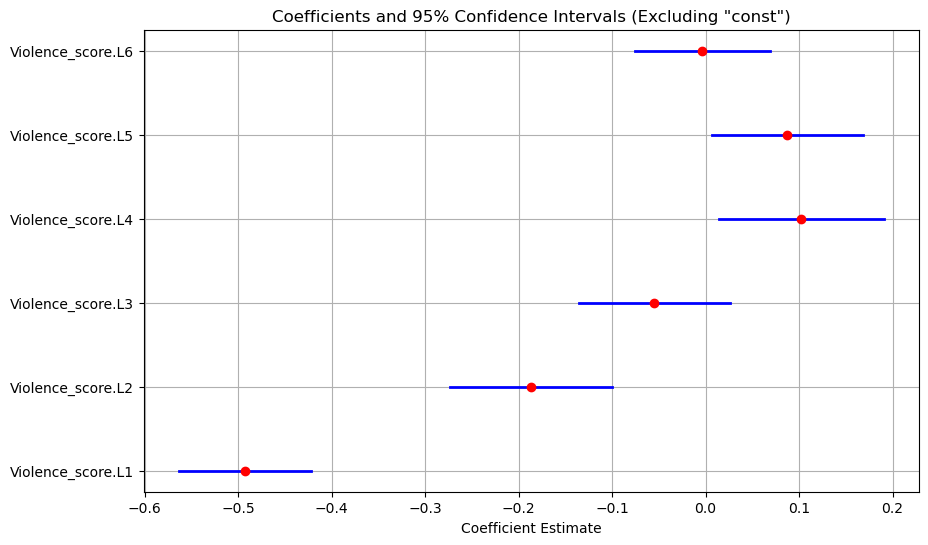

In [105]:
# Plot the 95% confidence intervals for all important coefficients
plot_coefficients_with_confidence_intervals(results_2_with_TFE_single_state)

#### Single state (example here: North Dakota) without time-fixed effects:

In [106]:
# create ARDL model with optimal lags and exclude time-fixed effects
model_2_without_TFE_single_state = ARDL_model_func(df_box_offices, df_real_violence_ratio, time_fixed_effects=False)

In [107]:
# extract the fitted model summary data, return the results dataframe and also store as HTML table (inside function) for embedding into website
results_2_without_TFE_single_state = extract_model_results(model_2_without_TFE_single_state, "Model 2 without TFE single state", "../data/CLEAN/")

In [108]:
# plot the summary of the fitted model (if needed)
#model_2_without_TFE_single_state.summary()

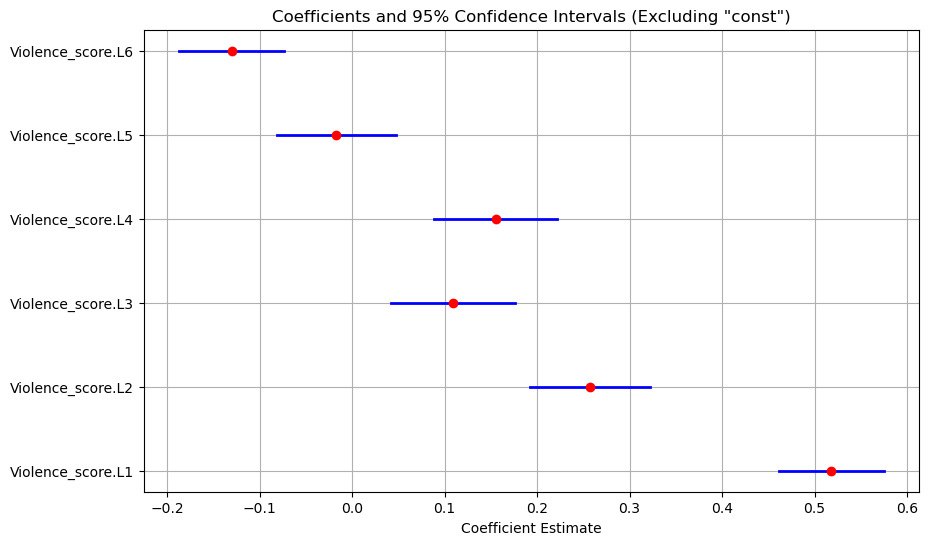

In [109]:
# Plot the 95% confidence intervals for all important coefficients
plot_coefficients_with_confidence_intervals(results_2_without_TFE_single_state)

### Model 3: Normalized box office revenues

In the third approach, we normalize the box office revenues for violent films but keep the violence offense counts as they are: 

* box office revenues: fill NaN values of box office revenues with median, divide all values by the median, then sum up these values for the violent movies in week i
* violent movie release count: count of violent movies released in week i
* real violence: number of all violent criminal offenses registered in week i

*Note: Due to the analogous proceeding for all cases (all states/single state, with time-fixed effects/without time-fixed effects) we only show here the results for the example single state North Dakota, since we then can use a longer time period as for all states merged. North Dakota is particularly interesting since we have nearly complete data for 1991 to 2012.*

#### Single state (example here: North Dakota) with time-fixed effects:

In [53]:
# load the normalised box office revenues
df_box_offices_norm = pd.read_csv(DATA_PATH+"/movie_violence_metric.csv", sep=",")
df_box_offices_norm.columns.values[2] = "Box office revenue"

In [110]:
# load the violent offenses counts for one single state (here: NorthDakota)
df_real_violence_counts = pd.read_csv(DATA_PATH+"/FBI_91_12/Violence_Score_COUNTS/SouthCarolina_violence.csv", sep=",")

In [56]:
# create ARDL model with optimal lags and include time-fixed effects
model_3_with_TFE_single_state = ARDL_model_func(df_box_offices_norm, df_real_violence_counts, time_fixed_effects=True)

In [57]:
# extract the fitted model summary data, return the results dataframe and also store as HTML table (inside function) for embedding into website
results_3_with_TFE_single_state = extract_model_results(model_3_with_TFE_single_state, "Model 3 with TFE single state", "../data/CLEAN/")

In [58]:
# plot the summary of the fitted model (if needed)
#model_3_with_TFE_single_state.summary()

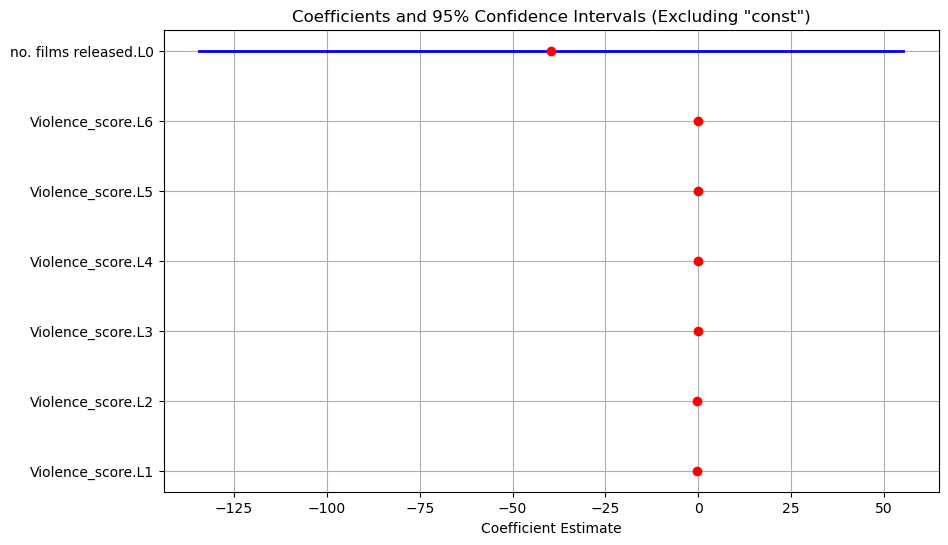

In [59]:
# Plot the 95% confidence intervals for all important coefficients
plot_coefficients_with_confidence_intervals(results_3_with_TFE_single_state)

#### Single state (example here: North Dakota) without time-fixed effects:

In [60]:
# create ARDL model with optimal lags and include time-fixed effects
model_3_without_TFE_single_state = ARDL_model_func(df_box_offices_norm, df_real_violence_counts, time_fixed_effects=False)

In [61]:
# extract the fitted model summary data, return the results dataframe and also store as HTML table (inside function) for embedding into website
results_3_without_TFE_single_state = extract_model_results(model_3_without_TFE_single_state, "Model 3 without TFE single state", "../data/CLEAN/")

In [62]:
# plot the summary of the fitted model (if needed)
#model_3_without_TFE_single_state.summary()

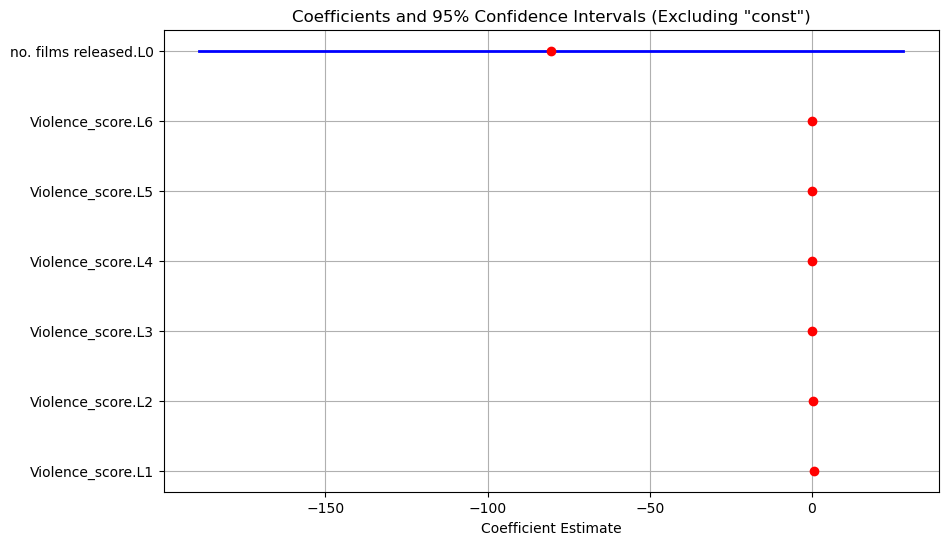

In [63]:
# Plot the 95% confidence intervals for all important coefficients
plot_coefficients_with_confidence_intervals(results_3_without_TFE_single_state)

### Model 4: Z-score for violence offenses

In the fourth approach, we compute the z-score for the violence offenses but keep the box office revenues as they are.

* box office revenues: sum of box office revenues of violent movies in week i
* violent movie release count: count of violent movies released in week i
* real violence: z-score of the offense counts for each category of offense ('Assault Offenses', 'Robbery', 'Sex Offenses', 'Kidnapping/Abduction', 'Arson', 'Homicide Offenses') using a rolling window of the same size as the maximum auto-regressive lag of the ARDL model for the normalization; reference point is the week i

*Note: Due to the analogous proceeding for all cases (all states/single state, with time-fixed effects/without time-fixed effects) we only show here the results for the example single state North Dakota, since we then can use a longer time period as for all states merged. North Dakota is particularly interesting since we have nearly complete data for 1991 to 2012.*

#### Single state (example here: North Dakota) with time-fixed effects:

In [43]:
data = pd.read_csv("../data/RAW/FBI_91_12/SouthCarolina_violence.csv")

all_dataframes = []

# Loop through each year from 1991 to 2008 (inclusive)
for year in range(1991, 2009):  # Note: range's stop is exclusive, so 2009 is the upper limit
    # Call the function for each year with the desired parameters
    df = violence_score_z_score_aggregated(data, year, start_week=1, stop_week=52, window_size=6)
    
    # Append the result to the list
    all_dataframes.append(df)

# Concatenate all the dataframes in the list into a single dataframe
final_dataframe = pd.concat(all_dataframes, ignore_index=True)

/Users/raphael_hellmann/Library/CloudStorage/OneDrive-epfl.ch/MA_3/ADA/Group_Project/ada-2024-project-alligatorsdontapologize24/tests/../src/model/ARDL_model.py:390: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_with_z_score =pd.concat([data_with_z_score,z_score_category],axis=0)
/Users/raphael_hellmann/Library/CloudStorage/OneDrive-epfl.ch/MA_3/ADA/Group_Project/ada-2024-project-alligatorsdontapologize24/tests/../src/model/ARDL_model.py:390: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  da

In [45]:
final_dataframe.to_csv("../data/CLEAN/FBI_91_12/SouthCarolina_z_scores.csv", index=False)

In [64]:
# load the z-score values for one single state (here: NorthDakota)
df_real_violence_zscores = pd.read_csv(DATA_PATH+"/FBI_91_12/SouthCarolina_z_scores.csv", sep=",")

In [65]:
# create ARDL model with optimal lags and include time-fixed effects
model_4_with_TFE_single_state = ARDL_model_func(df_box_offices, df_real_violence_zscores, time_fixed_effects=True)

In [66]:
# extract the fitted model summary data, return the results dataframe and also store as HTML table (inside function) for embedding into website
results_4_with_TFE_single_state = extract_model_results(model_4_with_TFE_single_state, "Model 4 with TFE single state", "../data/CLEAN/")

In [67]:
# plot the summary of the fitted model (if needed)
#model_4_with_TFE_single_state.summary()

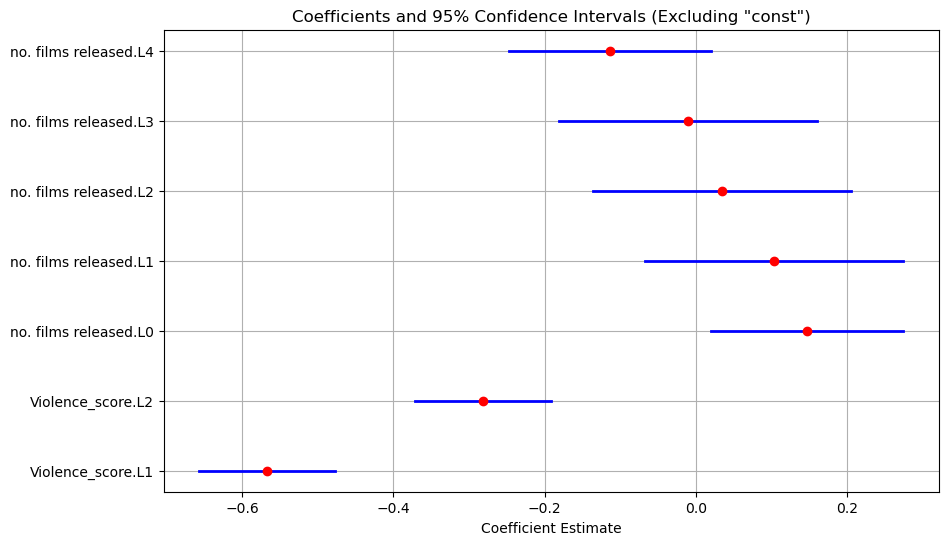

In [68]:
# Plot the 95% confidence intervals for all important coefficients
plot_coefficients_with_confidence_intervals(results_4_with_TFE_single_state)

#### Single state (example here: North Dakota) without time-fixed effects:

In [69]:
# create ARDL model with optimal lags and include time-fixed effects
model_4_without_TFE_single_state = ARDL_model_func(df_box_offices, df_real_violence_zscores, time_fixed_effects=False)

In [72]:
# extract the fitted model summary data, return the results dataframe and also store as HTML table (inside function) for embedding into website
results_4_without_TFE_single_state = extract_model_results(model_4_without_TFE_single_state, "Model 4 without TFE single state", "../data/CLEAN/")

In [73]:
# plot the summary of the fitted model (if needed)
#model_4_without_TFE_single_state.summary()

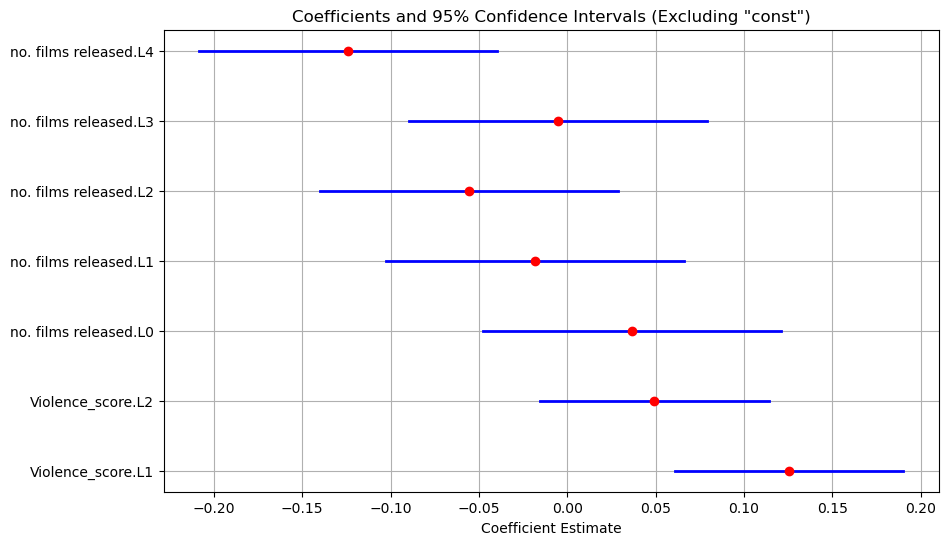

In [74]:
# Plot the 95% confidence intervals for all important coefficients
plot_coefficients_with_confidence_intervals(results_4_without_TFE_single_state)

### Model 5 (Final Model): Z-scores for violence offenses + normalized box office revenues

In the final approach, we compute the z-score for the violence offenses and normalize the box office revenues as in approach 3.

* box office revenues: fill NaN values of box office revenues with median, divide all values by the median, then sum up these values for the violent movies in week i
* violent movie release count: count of violent movies released in week i
* real violence: z-score of the offense counts for each category of offense ('Assault Offenses', 'Robbery', 'Sex Offenses', 'Kidnapping/Abduction', 'Arson', 'Homicide Offenses') using a rolling window of the same size as the maximum auto-regressive lag of the ARDL model for the normalization; reference point is the week i

#### Single state (example here: North Dakota) with time-fixed effects:

In [75]:
# create ARDL model with optimal lags and include time-fixed effects
model_5_with_TFE_single_state = ARDL_model_func(df_box_offices_norm, df_real_violence_zscores, time_fixed_effects=True)

In [76]:
# extract the fitted model summary data, return the results dataframe and also store as HTML table (inside function) for embedding into website
results_5_with_TFE_single_state = extract_model_results(model_5_with_TFE_single_state, "Model 5 with TFE single state", "../data/CLEAN/")

In [77]:
# plot the summary of the fitted model (if needed)
#model_5_with_TFE_single_state.summary()

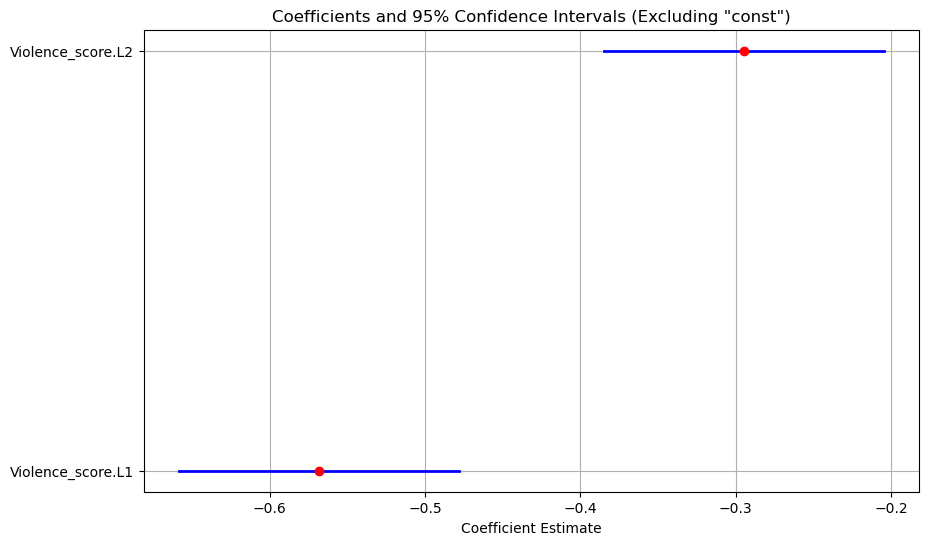

In [78]:
# Plot the 95% confidence intervals for all important coefficients
plot_coefficients_with_confidence_intervals(results_5_with_TFE_single_state)

#### Single state (example here: North Dakota) without time-fixed effects:

In [79]:
# create ARDL model with optimal lags and include time-fixed effects
model_5_without_TFE_single_state = ARDL_model_func(df_box_offices, df_real_violence_zscores, time_fixed_effects=False)

In [80]:
# extract the fitted model summary data, return the results dataframe and also store as HTML table (inside function) for embedding into website
results_5_without_TFE_single_state = extract_model_results(model_5_without_TFE_single_state, "Model 5 without TFE single state", "../data/CLEAN/")

In [81]:
# plot the summary of the fitted model (if needed)
#model_5_without_TFE_single_state.summary()

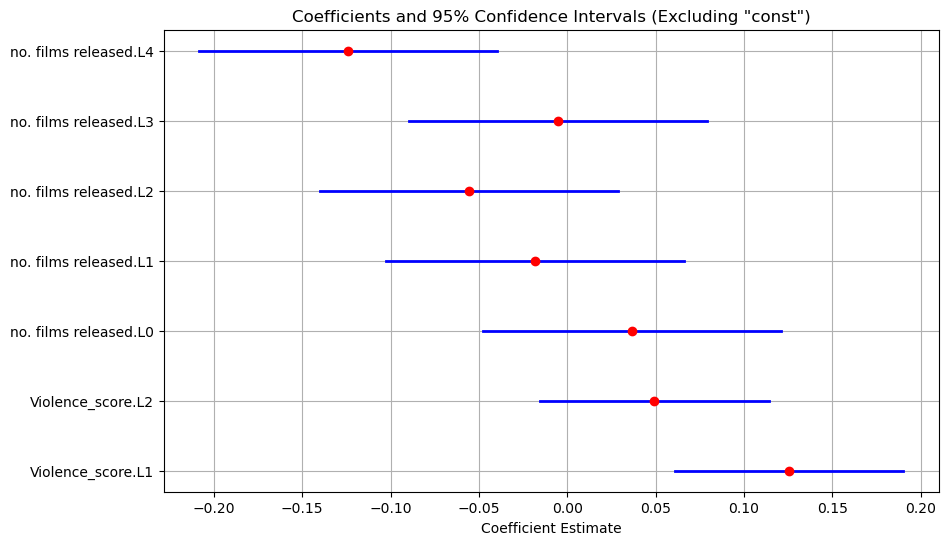

In [82]:
# Plot the 95% confidence intervals for all important coefficients
plot_coefficients_with_confidence_intervals(results_5_without_TFE_single_state)

#### All states merged with time-fixed effects:

In [83]:
# load the merged z-score for all states for real violence
df_real_violence_zscores_merged = pd.read_csv(DATA_PATH+"/FBI_91_12/04_Violence_z/Violence_z_all_states_merged.csv", sep=",")

In [84]:
# cut the real_violence dataframe to only include years from 2008 onwards -> to ensure we have complete data for all states
df_real_violence_zscores_cut = df_real_violence_zscores_merged[df_real_violence_zscores_merged['Year'] >= 2008]

In [85]:
# create ARDL model with optimal lags and include time-fixed effects
model_5_with_TFE_all_states = ARDL_model_func(df_box_offices_norm, df_real_violence_zscores_cut, time_fixed_effects=True)

In [86]:
# extract the fitted model summary data, return the results dataframe and also store as HTML table (inside function) for embedding into website
results_5_with_TFE_all_states = extract_model_results(model_5_with_TFE_all_states, "Model 5 with TFE all states", "../data/CLEAN/")

In [87]:
# plot the summary of the fitted model (if needed)
#model_5_with_TFE_all_states.summary()

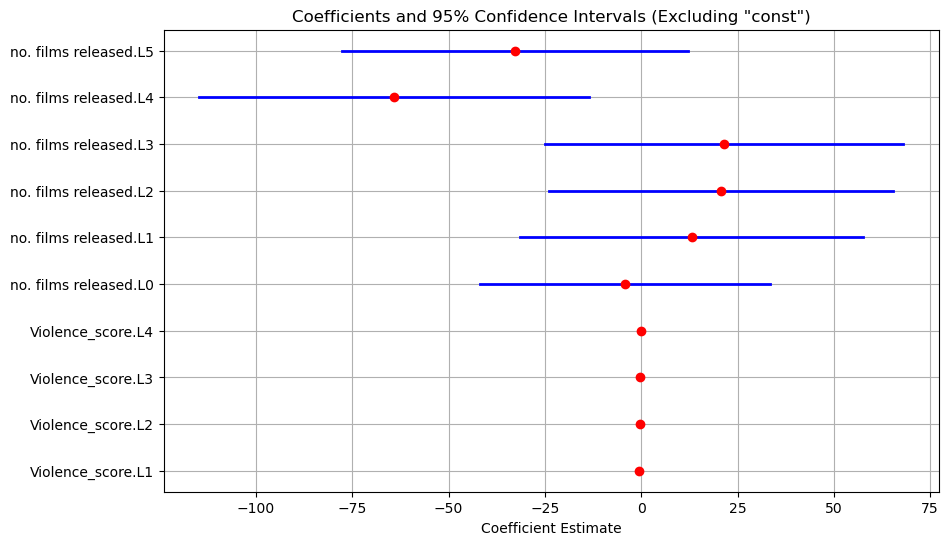

In [88]:
# Plot the 95% confidence intervals for all important coefficients
plot_coefficients_with_confidence_intervals(results_5_with_TFE_all_states)

#### All states merged without time-fixed effects:

In [89]:
# create ARDL model with optimal lags and exclude time-fixed effects
model_5_without_TFE_all_states = ARDL_model_func(df_box_offices_norm, df_real_violence_zscores_cut, time_fixed_effects=False)

In [90]:
# extract the fitted model summary data, return the results dataframe and also store as HTML table (inside function) for embedding into website
results_5_without_TFE_all_states = extract_model_results(model_5_without_TFE_all_states, "Model 5 without TFE all states", "../data/CLEAN/")

In [91]:
# plot the summary of the fitted model (if needed)
#model_5_without_TFE_all_states.summary()

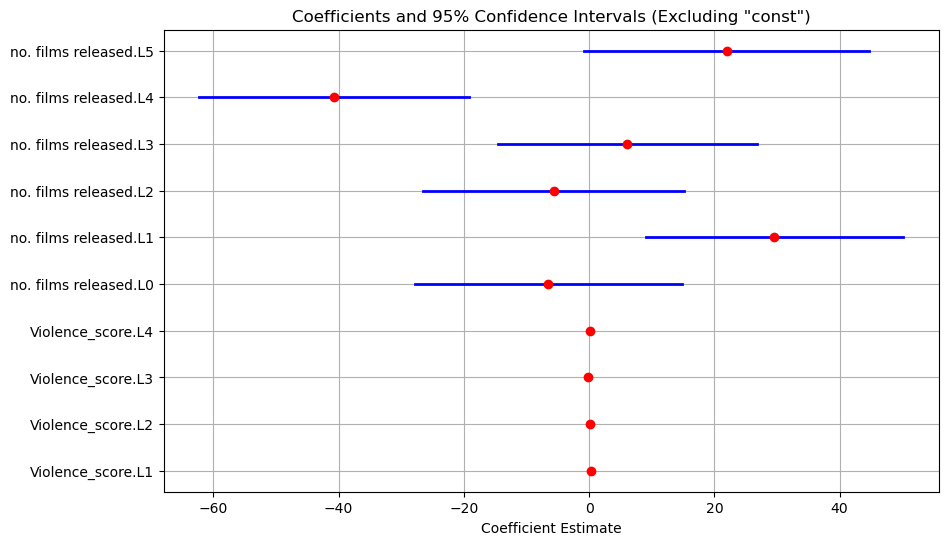

In [92]:
# Plot the 95% confidence intervals for all important coefficients
plot_coefficients_with_confidence_intervals(results_5_without_TFE_all_states)